In [1]:
# Import the libraries.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 as cv

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Concatenate, MaxPool2D, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras.backend import clear_session

In [2]:
# Download the Oxford-IIIT pet dataset.
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC1W0EL/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC1W0EL/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# Functions of the histogram equalization for color images.

# Converting RBG scale image to YPbPr scale.
def RGB2YPbPr(image):
    Kr, Kg, Kb = 0.299, 0.587, 0.114
    ConvertMat = tf.constant([Kr, Kg, Kb, 
                              -Kr/2/(1-Kb), -Kg/2/(1-Kb), 1/2,
                              1/2, -Kg/2/(1-Kr), -Kb/2/(1-Kr)], shape=[3,3])
    ypbpr = tf.linalg.matmul(ConvertMat, tf.cast(tf.transpose(tf.reshape(image, [-1,3])), tf.float32))
    ypbpr = tf.reshape(tf.transpose(ypbpr), [128, 128, 3])
    return ypbpr

# Converting YPbPr scale image back to RGB scale. 
def YPbPr2RGB(image):
    Kr, Kg, Kb = 0.299, 0.587, 0.114
    ConvertMat = tf.constant([1, 0, 2-2*Kr,
                              1, -Kb*(2-2*Kb)/Kg, -Kr*(2-2*Kr)/Kg,
                              1, 2-2*Kb, 0], shape=[3,3])
    rgb = tf.linalg.matmul(ConvertMat, tf.cast(tf.transpose(tf.reshape(image, [-1,3])), tf.float32))
    rgb = tf.reshape(tf.transpose(rgb), [128, 128, 3])
    return rgb

# The body of the histogram equalization.
def HistogramEqualization(image):
    ypbpr = RGB2YPbPr(image)
    he = tf.constant(0, shape=(128, 128, 0), dtype=tf.float32)

    histY = tf.histogram_fixed_width(tf.cast(tf.reshape(ypbpr[:,:,0], shape=[-1]), tf.float32), [0., 1.], 256)
    cdfY = tf.cumsum(histY)
    mappingY = tf.cast(cdfY, tf.float32) / tf.cast(128*128-1, tf.float32)
    heY = tf.reshape(tf.gather(mappingY, tf.cast(tf.reshape(ypbpr[:,:,0]*255., shape=[-1]), tf.int32)), shape=[128,128,1])
    heY = tf.clip_by_value(heY, clip_value_min=0., clip_value_max=1.)
    he = tf.concat([he, heY], axis=2)
    he = tf.concat([he, ypbpr[:,:,1:]], axis=2)

    rgb = YPbPr2RGB(he)
    rgb = tf.clip_by_value(rgb, clip_value_min=0., clip_value_max=1.)
    return rgb

In [91]:
# Preprocessing the data.
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = HistogramEqualization(input_image)

    return input_image, input_mask

In [92]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

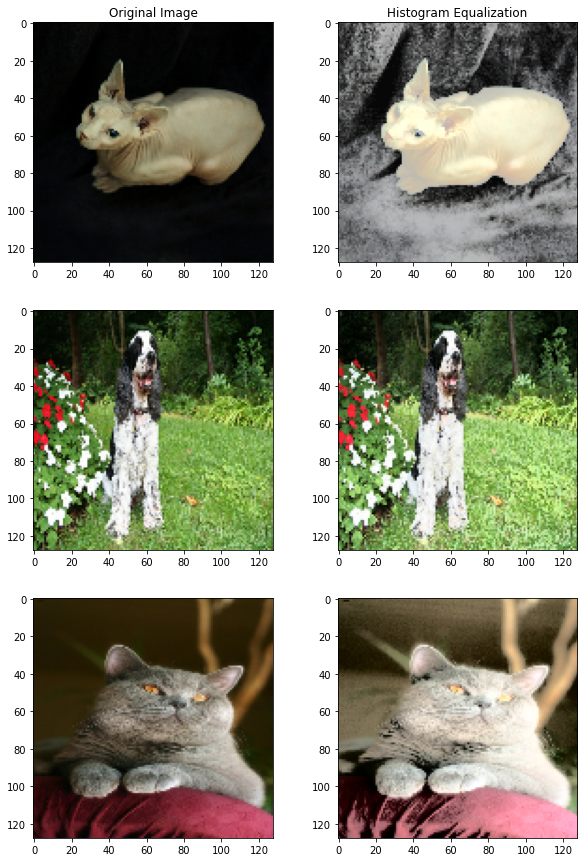

In [93]:
# Sanity check of the histogram equalization.
plt.figure(figsize=(10,15))
iter_data = iter(train_images)
for i in range(3):
    data = next(iter_data)
    plt.subplot(3,2,2*i+1)
    if i==0:
        plt.title("Original Image")
    plt.imshow(data[0])
    plt.subplot(3,2,2*i+2)
    if i==0:
        plt.title("Histogram Equalization")
    plt.imshow(HistogramEqualization(data[0]))
plt.show()

In [7]:
# Data augmentation.
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [8]:
# Defining the network.
input = Input(shape=[128, 128, 3])

x64 = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input)
x64 = BatchNormalization()(x64)
x64 = LeakyReLU(0.2)(x64)
x64 = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(x64)
x64 = BatchNormalization()(x64)
x64 = LeakyReLU(0.2)(x64)
x64 = MaxPool2D(pool_size=(2,2))(x64)
x32 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x64)
x32 = BatchNormalization()(x32)
x32 = LeakyReLU(0.2)(x32)
x32 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x32)
x32 = BatchNormalization()(x32)
x32 = LeakyReLU(0.2)(x32)
x32 = MaxPool2D(pool_size=(2,2))(x32)
x16 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x32)
x16 = BatchNormalization()(x16)
x16 = LeakyReLU(0.2)(x16)
x16 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x16)
x16 = BatchNormalization()(x16)
x16 = LeakyReLU(0.2)(x16)
x16 = MaxPool2D(pool_size=(2,2))(x16)
x8 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(x16)
x8 = BatchNormalization()(x8)
x8 = LeakyReLU(0.2)(x8)
x8 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(x8)
x8 = BatchNormalization()(x8)
x8 = LeakyReLU(0.2)(x8)
x8 = MaxPool2D(pool_size=(2,2))(x8)
x4 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(x8)
x4 = BatchNormalization()(x4)
x4 = LeakyReLU(0.2)(x4)
x4 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(x4)
x4 = BatchNormalization()(x4)
x4 = LeakyReLU(0.2)(x4)
x4 = MaxPool2D(pool_size=(2,2))(x4)

x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same')(x4)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Concatenate()([x, x8])
x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Concatenate()([x, x16])
x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Concatenate()([x, x32])
x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Concatenate()([x, x64])
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
output = Conv2D(filters=3, kernel_size=1, strides=1, padding='same', activation='softmax')(x)

In [9]:
# Setting the learning rate, learning rate decay, optimizer, and loss function.
clear_session()
model = Model(inputs=input, outputs=output)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,
                                                             decay_steps=100,
                                                             decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [90]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
# Training parameteres.
batch_size = 64
epochs = 40
buffer_size = 1000
train_size = info.splits['train'].num_examples

In [12]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)

In [13]:
# The actual training is done in this cell.
hist = model.fit(train_batches,
                 batch_size=batch_size, 
                 epochs=epochs,
                 steps_per_epoch=int(train_size/batch_size),
                 shuffle=True,
                 verbose=2,
                 validation_data=test_batches)

Epoch 1/40
57/57 - 41s - loss: 0.7450 - accuracy: 0.6722 - val_loss: 5382.0093 - val_accuracy: 0.2957 - 41s/epoch - 720ms/step
Epoch 2/40
57/57 - 19s - loss: 0.5931 - accuracy: 0.7520 - val_loss: 19.4218 - val_accuracy: 0.4423 - 19s/epoch - 336ms/step
Epoch 3/40
57/57 - 19s - loss: 0.5460 - accuracy: 0.7733 - val_loss: 11.1458 - val_accuracy: 0.3517 - 19s/epoch - 330ms/step
Epoch 4/40
57/57 - 19s - loss: 0.5188 - accuracy: 0.7846 - val_loss: 2.2505 - val_accuracy: 0.5779 - 19s/epoch - 336ms/step
Epoch 5/40
57/57 - 19s - loss: 0.4975 - accuracy: 0.7938 - val_loss: 0.6771 - val_accuracy: 0.7629 - 19s/epoch - 337ms/step
Epoch 6/40
57/57 - 19s - loss: 0.4717 - accuracy: 0.8053 - val_loss: 0.5569 - val_accuracy: 0.7862 - 19s/epoch - 340ms/step
Epoch 7/40
57/57 - 19s - loss: 0.4553 - accuracy: 0.8126 - val_loss: 0.5283 - val_accuracy: 0.7897 - 19s/epoch - 340ms/step
Epoch 8/40
57/57 - 19s - loss: 0.4255 - accuracy: 0.8252 - val_loss: 0.6097 - val_accuracy: 0.7519 - 19s/epoch - 340ms/step
Epo

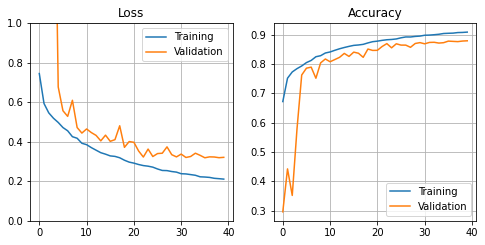

In [14]:
# Visualization of the training process.
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.grid()
plt.ylim(0.0,1.0)
plt.title("Loss")
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], label="Training")
plt.plot(hist.history['val_accuracy'], label="Validation")
plt.legend()
plt.grid()
plt.title("Accuracy")
plt.savefig("training.png", bbox_inches='tight')
plt.show()

In [15]:
# A function to produce a 1D Gaussian filter.
def gaussian_1d(size=3, sigma=3):
    _size = (size-1)/2
    filter = np.arange(-_size, _size+1)
    filter = filter / _size * sigma
    filter = np.exp(-filter**2/2)
    filter = filter / np.sum(filter)
    return filter

In [101]:
# A function to make the background blurred using the model prediction.
def gaussian_blur(image, pred, filter_size=3, pad_val=0.5):
    mask = (pred==0).reshape(128,128,1)
    mask = np.concatenate([mask, mask, mask], axis=2)
    _image = image.copy()
    # _image[mask] = pad_val
    image_padded = np.ones((128+filter_size-1, 128+filter_size-1, 3)) * pad_val
    image_padded[int((filter_size-1)/2):int((filter_size-1)/2)+128, int((filter_size-1)/2):int((filter_size-1)/2)+128, :] = _image
    blurred_1 = np.zeros((128,128+filter_size-1,3))
    blurred_2 = np.zeros((128,128,3))
    g_filter = gaussian_1d(filter_size)
    for i in range(128):
        for j in range(128+filter_size-1):
            for k in range(-int((filter_size-1)/2), int((filter_size+1)/2)):
                blurred_1[i,j,:] += image_padded[i+int((filter_size-1)/2)+k, j, :] * g_filter[k+int((filter_size-1)/2)]
    for i in range(128):
        for j in range(128):
            for k in range(-int((filter_size-1)/2), int((filter_size+1)/2)):
                blurred_2[i,j,:] += blurred_1[i,j+int((filter_size-1)/2)+k,:] * g_filter[k+int((filter_size-1)/2)]
    blurred = np.clip(blurred_2, a_min=0.0, a_max=1.0)
    blurred[mask] = 0.
    image[np.logical_not(mask)] = 0.
    blurred += image
    return blurred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

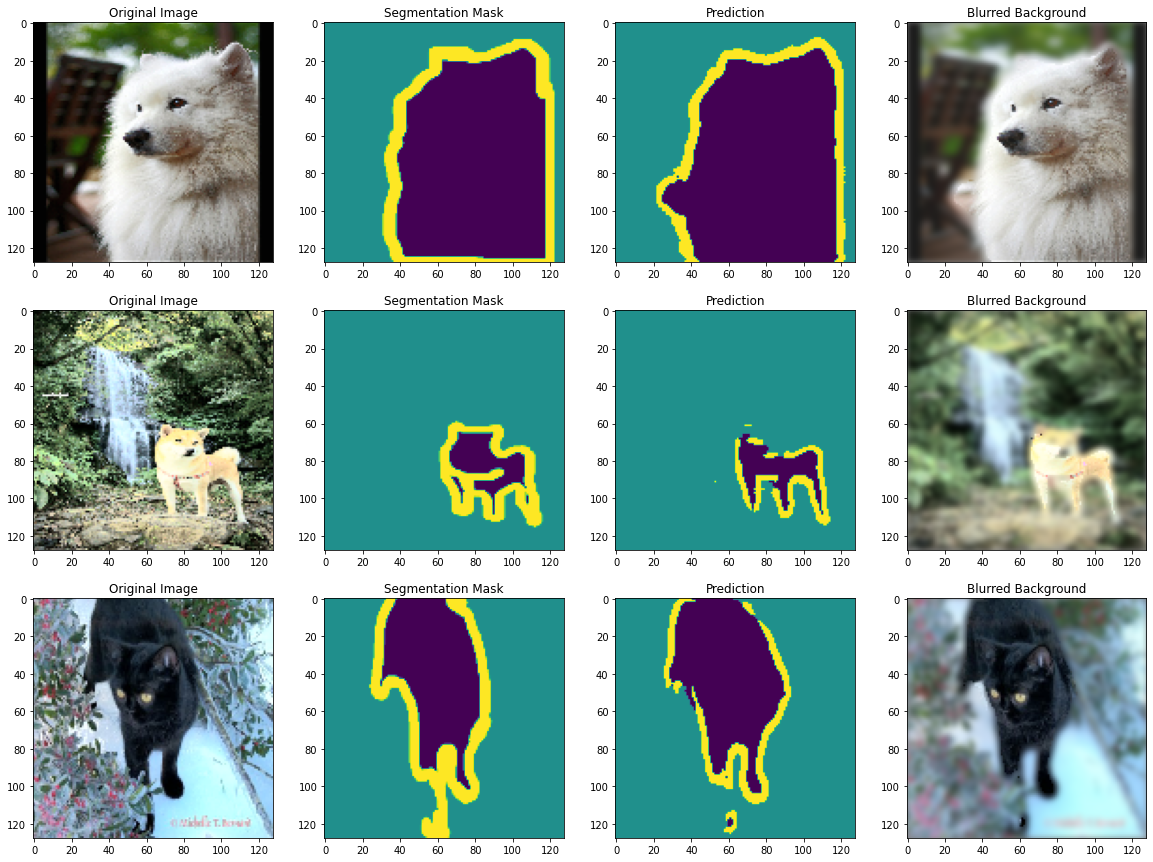

In [102]:
# Examples of how our model works.
gaussian_filter_size = 11
plt.figure(figsize=(20,15))
for images, masks in test_batches.take(3):
    prediction = model.predict(images)
    for i in range(3):
        image, mask, pred = images[i], masks[i], prediction[i]
        pred = np.argmax(pred, axis=2)
        plt.subplot(3,4,4*i+1)
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.title("Original Image")
        plt.subplot(3,4,4*i+2)
        plt.imshow(tf.keras.utils.array_to_img(mask))
        plt.title("Segmentation Mask")
        plt.subplot(3,4,4*i+3)
        plt.imshow(pred)
        plt.title("Prediction")
        plt.subplot(3,4,4*i+4)
        blurred = gaussian_blur(image.numpy(), pred, filter_size=gaussian_filter_size)
        plt.imshow(blurred)
        plt.title("Blurred Background")
plt.savefig("result.png", bbox_inches="tight")
plt.show()

In [63]:
# A function of replacing the background with a given image.
space, tandon = cv.imread("space.png"), cv.imread("tandon.png")
space, tandon = cv.cvtColor(space, cv.COLOR_BGR2RGB), cv.cvtColor(tandon, cv.COLOR_BGR2RGB)
space, tandon = cv.resize(space, (128,128))/255., cv.resize(tandon, (128,128))/255.

def replace_background(image, pred, background):
    mask = (pred==0).reshape(128,128,1)
    mask = np.concatenate([mask, mask, mask], axis=2)
    _image, _background = image.copy(), background.copy()
    _image[np.logical_not(mask)] = 0.
    _background[mask] = 0.
    replaced = _image + _background
    return replaced

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

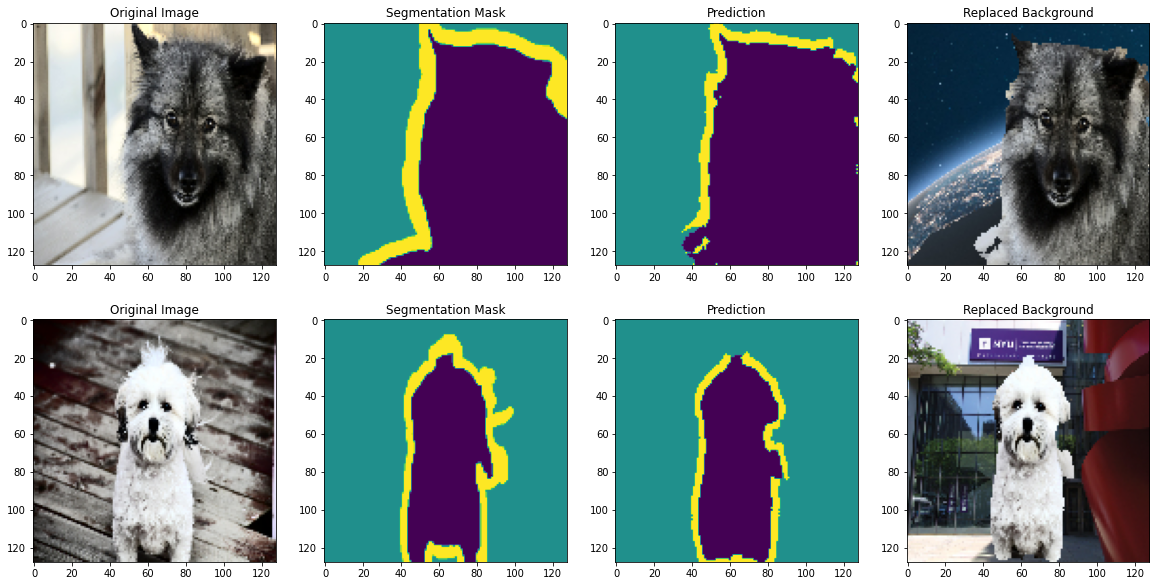

In [72]:
# Examples of how our model works.
backgrounds = [space, tandon]
plt.figure(figsize=(20,10))
for images, masks in test_batches.take(2):
    prediction = model.predict(images)
    for i in range(2):
        image, mask, pred = images[i], masks[i], prediction[i]
        pred = np.argmax(pred, axis=2)
        plt.subplot(2,4,4*i+1)
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.title("Original Image")
        plt.subplot(2,4,4*i+2)
        plt.imshow(tf.keras.utils.array_to_img(mask))
        plt.title("Segmentation Mask")
        plt.subplot(2,4,4*i+3)
        plt.imshow(pred)
        plt.title("Prediction")
        plt.subplot(2,4,4*i+4)
        img = replace_background(image.numpy(), pred, backgrounds[i])
        plt.imshow(img)
        plt.title("Replaced Background")
plt.savefig("result2.png", bbox_inches="tight")
plt.show()

In [118]:
# Loading images from the Internet.
lion, dog, tomjerry = cv.imread("lion.jpeg"), cv.imread("dog.jpg"), cv.imread("tomandjerry.jpg")
lion, dog, tomjerry = cv.cvtColor(lion, cv.COLOR_BGR2RGB), cv.cvtColor(dog, cv.COLOR_BGR2RGB), cv.cvtColor(tomjerry, cv.COLOR_BGR2RGB)
lion, dog, tomjerry = cv.resize(lion, (128,128))/255., cv.resize(dog, (128,128))/255., cv.resize(tomjerry, (128,128))/255.
inet_samples = [lion, dog, tomjerry]

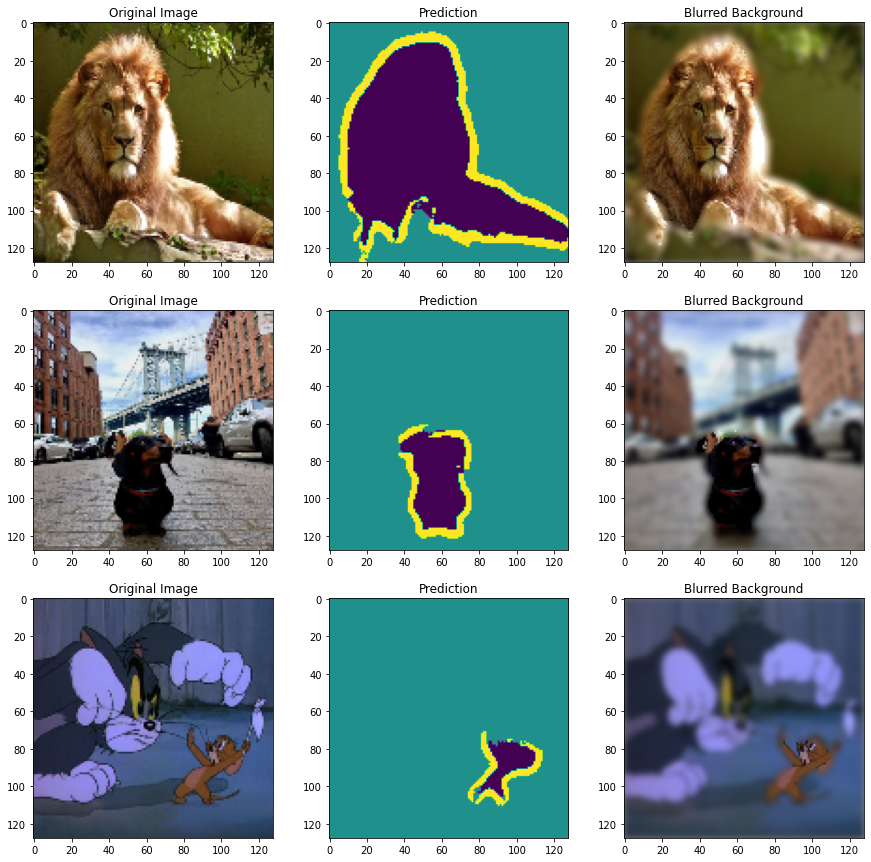

In [105]:
# Examples of how our model works.
gaussian_filter_size = 11
plt.figure(figsize=(15,15))
for i in range(3):
    image = inet_samples[i]
    pred = model.predict(image.reshape(1,128,128,3)).reshape(128,128,3)
    pred = np.argmax(pred, axis=2)
    plt.subplot(3,3,3*i+1)
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.title("Original Image")
    plt.subplot(3,3,3*i+2)
    plt.imshow(pred)
    plt.title("Prediction")
    plt.subplot(3,3,3*i+3)
    blurred = gaussian_blur(image, pred, filter_size=gaussian_filter_size)
    plt.imshow(blurred)
    plt.title("Blurred Background")
plt.savefig("result3.png", bbox_inches="tight")
plt.show()

In [121]:
# Circling the lion with a red line based on model prediction.
pred = model.predict(lion.reshape(1,128,128,3)).reshape(128,128,3)
pred = np.argmax(pred, axis=2)
red = np.array([[[1., 0., 0.]]])
lion_edge = lion.copy()
for i in range(1,127):
    for j in range(1,127):
        if pred[i,j]==2:
            if pred[i-1,j]==1:
                lion_edge[i,j,:] = red
            elif pred[i+1,j]==1:
                lion_edge[i,j,:] = red
            elif pred[i,j-1]==1:
                lion_edge[i,j,:] = red
            elif pred[i,j+1]==1:
                lion_edge[i,j,:] = red

In [130]:
# Canny edge detector mostly from the project 2.
def cross_correlation(f, I):
    pad_size = [f.shape[0]//2, f.shape[1]//2]
    im_pad = np.zeros((I.shape[0]+pad_size[0]*2, I.shape[1]+pad_size[1]*2))
    im_pad[pad_size[0]:pad_size[0]+I.shape[0], pad_size[1]:pad_size[1]+I.shape[1]] = I
    im_corr = np.zeros(I.shape)
    for i in range(im_corr.shape[0]):
        for j in range(im_corr.shape[1]):
            for k in range(f.shape[0]):
                for l in range(f.shape[1]):
                    im_corr[i][j] += im_pad[i+k][j+l]*f[k][l]
    return im_corr

def gaussian(x, std):
    return 1/np.sqrt(2*np.pi)/std * np.exp(-x**2/2/std**2)

def gaussian_filter(stdev, extension, size):
    ret = np.arange(size)
    ret = ret - ret.mean()
    ret = ret / ret[-1] * stdev * extension
    ret = gaussian(ret, stdev)
    ret = ret / ret.sum()
    return ret

lion_canny = cv.cvtColor(cv.resize(cv.imread("lion.jpeg"),(128,128)), cv.COLOR_BGR2GRAY)

gaussian_filter_vert = gaussian_filter(1,3,5).reshape(1,-1)
gaussian_filter_hori = gaussian_filter(1,3,5).reshape(-1,1)
lion_canny = cross_correlation(gaussian_filter_vert, lion_canny)
lion_canny = cross_correlation(gaussian_filter_hori, lion_canny)

derivative_filter_vert = np.array([[-1, 0, 1]])
derivative_filter_hori = np.array([[-1], [0], [1]])
x_derivative = cross_correlation(derivative_filter_vert, lion_canny)
y_derivative = cross_correlation(derivative_filter_hori, lion_canny)
lion_canny = np.sqrt(x_derivative**2 + y_derivative**2)
grad_direc = np.arctan2(-y_derivative, x_derivative)

def non_maximum_supression(mag, direct):
    im_supression = np.zeros(mag.shape)
    direct = ((direct+np.pi/8) % np.pi / (np.pi/4)).astype(int)
    for i in range(mag.shape[0]):
        for j in range(mag.shape[1]):
            neighbor = 0
            if direct[i][j]==0:
                if j>0:
                    neighbor = max(neighbor, mag[i][j-1])
                if j<mag.shape[1]-1:
                    neighbor = max(neighbor, mag[i][j+1])
                if mag[i][j]>neighbor:
                    im_supression[i][j] = mag[i][j]
            elif direct[i][j]==1:
                if i>0 and j<mag.shape[1]-1:
                    neighbor = max(neighbor, mag[i-1][j+1])
                if i<mag.shape[0]-1 and j>0:
                    neighbor = max(neighbor, mag[i+1][j-1])
                if mag[i][j]>neighbor:
                    im_supression[i][j] = mag[i][j]
            elif direct[i][j]==2:
                if i>0:
                    neighbor = max(neighbor, mag[i-1][j])
                if i<mag.shape[0]-1:
                    neighbor = max(neighbor, mag[i+1][j])
                if mag[i][j]>neighbor:
                    im_supression[i][j] = mag[i][j]
            else:
                if i>0 and j>0:
                    neighbor = max(neighbor, mag[i-1][j-1])
                if i<mag.shape[0]-1 and j<mag.shape[1]-1:
                    neighbor = max(neighbor, mag[i+1][j+1])
                if mag[i][j]>neighbor:
                    im_supression[i][j] = mag[i][j]
    return im_supression

lion_canny = non_maximum_supression(lion_canny, grad_direc)
lion_canny_edge = lion.copy()
threshold = 30
for i in range(128):
    for j in range(128):
        if lion_canny[i,j]>threshold:
            lion_canny_edge[i,j,:] = red

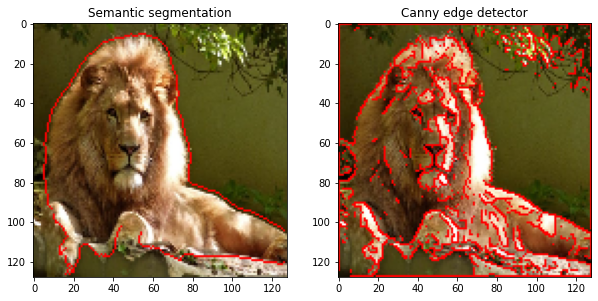

In [138]:
# Comparing the result.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(lion_edge)
plt.title("Semantic segmentation")
plt.subplot(1,2,2)
plt.imshow(lion_canny_edge)
plt.title("Canny edge detector")
plt.savefig("canny.png", bbox_inches="tight")
plt.show()